<a href="https://colab.research.google.com/github/saadan1234/Optical-Network-and-Technologies/blob/main/T5KnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Overview

1. Import EU Dataset
2. Train Teacher Model on EU Dataset
3. Knowledge Distillation - Hard Distillation on EU Dataset
4. Knowledge Distillation - Soft Distillation on EU Dataset
5. Time and Memory Comparison Analysis on EU Dataset
6. Import USA Dataset
7. Train Teacher Model on USA Dataset
8. Knowledge Distillation - Hard Distillation on USA Dataset
9. Knowledge Distillation - Soft Distillation on USA Dataset
10. Time and Memory Comparison Analysis on USA Dataset

# Importing Libraries

In [61]:
pip install memory-profiler


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time
from memory_profiler import memory_usage
import psutil
import os


# EU Data Import

In [1]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive to the specified folder (/content/drive)
# This allows access to files stored in your Google Drive from the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the file path for the Excel file stored in Google Drive
file_path = '/content/drive/MyDrive/DataSet_EU_3k_5k.xlsx'

# Use pandas to read the Excel file located at the specified file path
data = pd.read_excel(file_path)

In [6]:
# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_69,GSNR_70,GSNR_71,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,No. Spans,Total Distance(m)
0,0.000000,0.000000,0.000007,0.000007,0.000007,0.000000,0.000007,0.0,0.000007,0.0,...,90.061284,0.000000,0.000000,0.000000,0.000000,95.045789,0.000000,0.000000,8,690608.0
1,0.000000,0.000007,0.000000,0.000007,0.000000,0.000007,0.000000,0.0,0.000000,0.0,...,0.000000,92.560867,0.000000,0.000000,89.544975,0.000000,0.000000,0.000000,8,690608.0
2,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,90.991977,0.000000,0.000000,0.000000,85.512399,83.114113,8,690608.0
3,0.000007,0.000007,0.000007,0.000007,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,76.409583,73.664915,74.651700,79.071217,0.000000,0.000000,0.000000,0.000000,8,690608.0
4,0.000000,0.000000,0.000007,0.000000,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,78.299438,74.910765,72.030907,73.790264,81.190439,0.000000,8,690608.0


# Data Preparation

In [8]:
# Define the attribute columns and the target variable
attribute_columns = [f'Power_{i}' for i in range(1, 77)] + [f'ASE_{i}' for i in range(1, 77)] + [f'NLI_{i}' for i in range(1, 77)]+ ['No. Spans'] + ['Total Distance(m)']

# Label
target_column = 'GSNR_1'

Frequency is not included in the above data as it is proven to have no correlation with the label in the previous tasks.

### Normalization

In [9]:
# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.076798
4    0.000000
Name: Power_1, dtype: float64 0    0.075117
1    0.073203
2    0.073788
3    0.000062
4    0.071547
Name: ASE_1, dtype: float64 0    0.000000
1    0.000000
2    0.000000
3    0.017928
4    0.000000
Name: NLI_1, dtype: float64 0    0.037037
1    0.037037
2    0.037037
3    0.037037
4    0.037037
Name: No. Spans, dtype: float64 0    0.008849
1    0.008849
2    0.008849
3    0.008849
4    0.008849
Name: Total Distance(m), dtype: float64
    GSNR_1
0  0.00000
1  0.00000
2  0.00000
3  0.79791
4  0.00000


### Path Wise Split

In [13]:
# Define the function to split data according to the specified pattern
def custom_train_test_split(data, labels, samples_per_block=3000, train_samples_per_block=2500, test_samples_per_block=500):
    # Initialize lists to hold the training and testing data and labels
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    # Determine the total number of samples in the data
    total_samples = len(data)

    # Loop over the data in blocks of the specified size (samples_per_block)
    for start in range(0, total_samples, samples_per_block):
        # Define the end of the current block
        end = start + samples_per_block
        # Define the end of the training samples within the current block
        train_end = start + train_samples_per_block

        # Adjust train_end and end if they exceed the total number of samples
        if train_end > total_samples:
            train_end = total_samples
        if end > total_samples:
            end = total_samples

        # Append the training and testing data and labels for the current block to the respective lists
        train_data.append(data[start:train_end])
        test_data.append(data[train_end:end])
        train_labels.append(labels[start:train_end])
        test_labels.append(labels[train_end:end])

    # Concatenate the lists into DataFrames and reset the index
    train_data = pd.concat(train_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)
    train_labels = pd.concat(train_labels).reset_index(drop=True)
    test_labels = pd.concat(test_labels).reset_index(drop=True)

    # Return the training and testing data and labels
    return train_data, test_data, train_labels, test_labels

# Create a list of attribute columns excluding those that start with 'frequency'
attribute_columns_without_frequency = [col for col in attribute_columns if not col.startswith('frequency')]

# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns_without_frequency], y[target_column])

# Display shapes to verify the split
print("Normalized data with equal path distribution in train and test data :\n")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)

Normalized data with equal path distribution in train and test data :

Train data shape: (15000, 230)
Test data shape: (3000, 230)
Train labels shape: (15000,)
Test labels shape: (3000,)


# Teacher Model

In [67]:
# Define a large teacher model architecture
teacher_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the teacher model
history = teacher_model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the teacher model
val_loss, val_mae = teacher_model.evaluate(X_test, Y_test)
print(f"Validation MAE: {val_mae}")


Epoch 1/25
188/188 [==============================] - 3s 7ms/step - loss: 0.0372 - mae: 0.1271 - val_loss: 0.0030 - val_mae: 0.0432
Epoch 2/25
188/188 [==============================] - 1s 7ms/step - loss: 0.0026 - mae: 0.0307 - val_loss: 0.0025 - val_mae: 0.0299
Epoch 3/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0207 - val_loss: 0.0013 - val_mae: 0.0220
Epoch 4/25
188/188 [==============================] - 2s 11ms/step - loss: 8.8402e-04 - mae: 0.0161 - val_loss: 0.0033 - val_mae: 0.0361
Epoch 5/25
188/188 [==============================] - 2s 11ms/step - loss: 6.5589e-04 - mae: 0.0136 - val_loss: 0.0015 - val_mae: 0.0232
Epoch 6/25
188/188 [==============================] - 2s 9ms/step - loss: 5.0783e-04 - mae: 0.0122 - val_loss: 0.0024 - val_mae: 0.0283
Epoch 7/25
188/188 [==============================] - 1s 6ms/step - loss: 4.8305e-04 - mae: 0.0115 - val_loss: 0.0036 - val_mae: 0.0358
Epoch 8/25
188/188 [==============================] - 1s 6

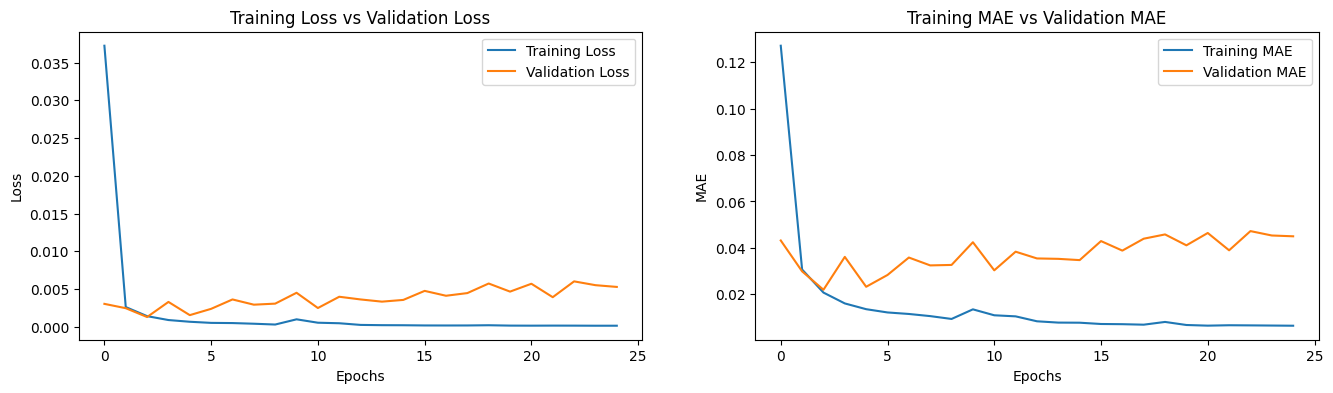

In [68]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Student Model

### Hard Distillation

In [69]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model
history_hard = student_model_hard.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the student model
val_loss_hard, val_mae_hard = student_model_hard.evaluate(X_test, Y_test)
print(f"Validation MAE (Hard Distillation): {val_mae_hard}")


Epoch 1/25
188/188 [==============================] - 2s 4ms/step - loss: 0.0841 - mae: 0.1941 - val_loss: 0.1071 - val_mae: 0.2923
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0448 - mae: 0.1510 - val_loss: 0.0690 - val_mae: 0.2433
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0296 - mae: 0.1190 - val_loss: 0.0201 - val_mae: 0.1278
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0135 - mae: 0.0788 - val_loss: 0.0052 - val_mae: 0.0501
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0070 - mae: 0.0546 - val_loss: 0.0027 - val_mae: 0.0347
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0052 - mae: 0.0458 - val_loss: 0.0011 - val_mae: 0.0239
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0045 - mae: 0.0410 - val_loss: 0.0051 - val_mae: 0.0475
Epoch 8/25
188/188 [==============================] - 1s 3ms/step - loss: 0.

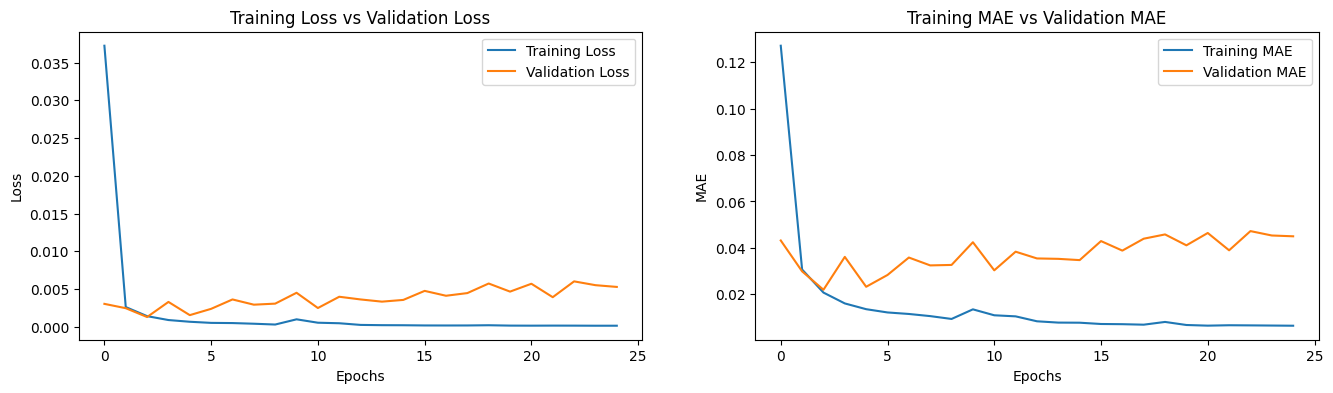

In [70]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


### Soft Distilaltion

In [71]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [72]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 5ms/step - loss: 0.0714 - mae: 0.1974 - val_loss: 0.0266 - val_mae: 0.1450
Epoch 2/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0188 - mae: 0.1068 - val_loss: 0.0200 - val_mae: 0.1265
Epoch 3/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0133 - mae: 0.0876 - val_loss: 0.0123 - val_mae: 0.0987
Epoch 4/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0089 - mae: 0.0705 - val_loss: 0.0060 - val_mae: 0.0647
Epoch 5/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0062 - mae: 0.0581 - val_loss: 0.0036 - val_mae: 0.0451
Epoch 6/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0051 - mae: 0.0518 - val_loss: 0.0030 - val_mae: 0.0391
Epoch 7/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0042 - mae: 0.0467 - val_loss: 0.0031 - val_mae: 0.0390
Epoch 8/25
188/188 [=

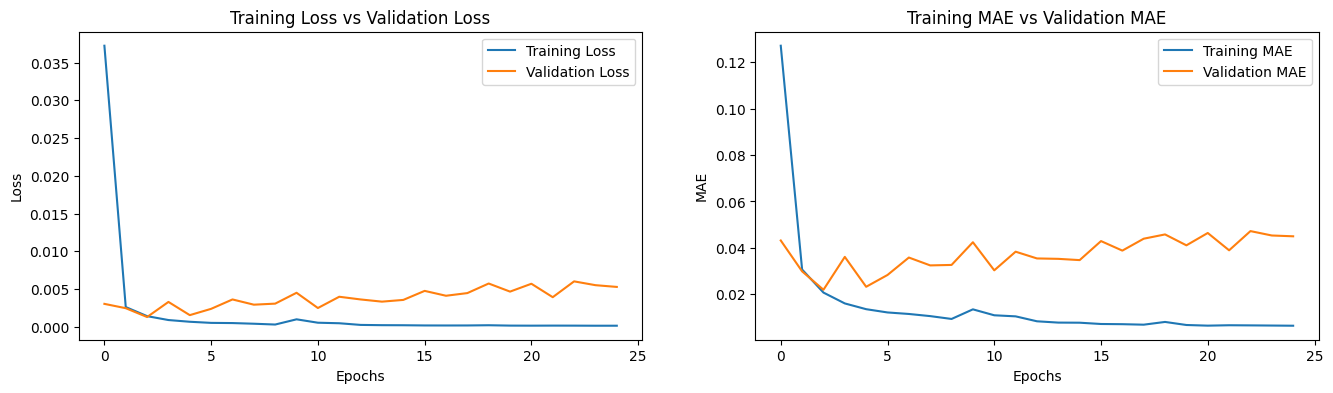

In [73]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [74]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 2s 3ms/step
Epoch 1/25
188/188 [==============================] - 2s 4ms/step - loss: 0.0695 - mae: 0.1955 - val_loss: 0.0229 - val_mae: 0.1359
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0178 - mae: 0.1030 - val_loss: 0.0160 - val_mae: 0.1119
Epoch 3/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0118 - mae: 0.0818 - val_loss: 0.0102 - val_mae: 0.0883
Epoch 4/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0084 - mae: 0.0685 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0062 - mae: 0.0592 - val_loss: 0.0040 - val_mae: 0.0463
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0046 - mae: 0.0508 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0021 - val_mae: 0.0324
Epoch 8/25
188/188 [=

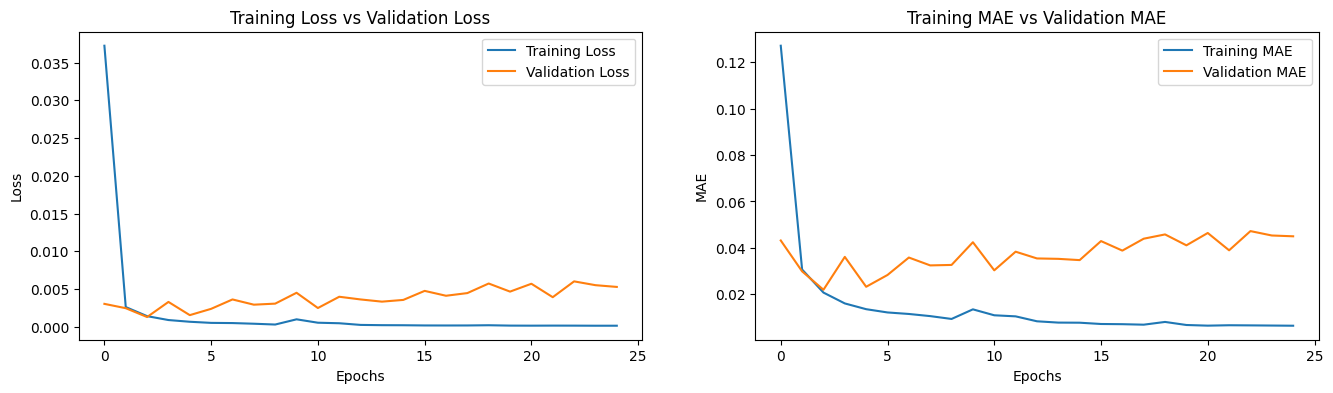

In [75]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [76]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 6ms/step - loss: 0.0825 - mae: 0.2091 - val_loss: 0.0238 - val_mae: 0.1404
Epoch 2/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0155 - mae: 0.0948 - val_loss: 0.0181 - val_mae: 0.1205
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0117 - mae: 0.0814 - val_loss: 0.0122 - val_mae: 0.0937
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0085 - mae: 0.0698 - val_loss: 0.0069 - val_mae: 0.0651
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0064 - mae: 0.0617 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0556 - val_loss: 0.0036 - val_mae: 0.0449
Epoch 7/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0044 - mae: 0.0497 - val_loss: 0.0026 - val_mae: 0.0369
Epoch 8/25
188/188 [=

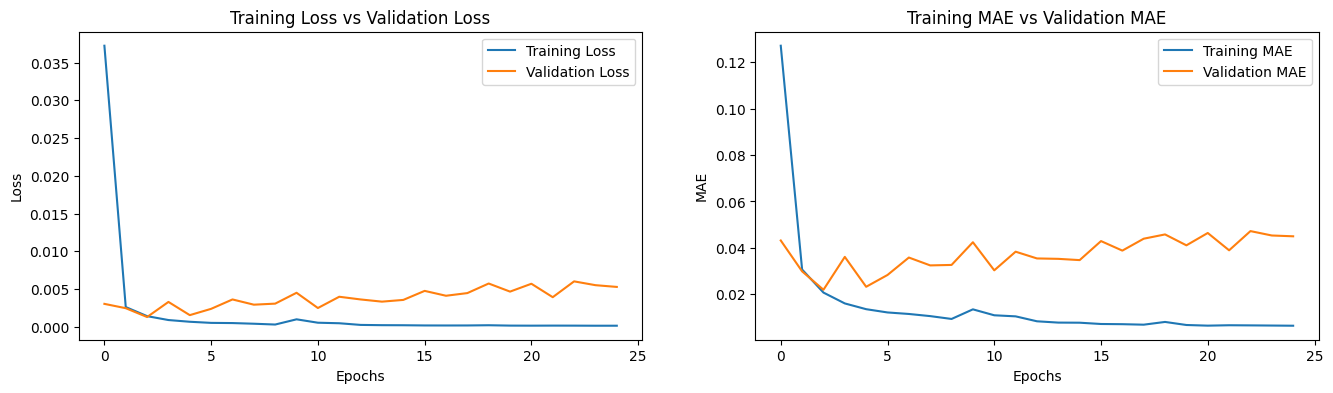

In [77]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Time Comparison

In [78]:
# Timing and memory usage measurement function
def measure_training_time_memory(model, x_train, y_train, epochs=50):
    start_time = time.time()
    mem_usage = memory_usage((model.fit, (x_train, y_train), {'epochs': epochs, 'batch_size': 32, 'validation_split': 0.2, 'callbacks': [tf.keras.callbacks.EarlyStopping(patience=5)]}), interval=0.1)
    end_time = time.time()
    training_time = end_time - start_time
    max_memory = max(mem_usage)
    return training_time, max_memory

In [79]:
# Prepare soft targets for soft distillation
temperature = 3
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)
Y_train = Y_train.reshape(-1, 1)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, Y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)



469/469 [==============================] - 1s 2ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 2s 6ms/step - loss: 1.5821e-04 - mae: 0.0074 - val_loss: 0.0059 - val_mae: 0.0478
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 2.4417e-04 - mae: 0.0086 - val_loss: 0.0057 - val_mae: 0.0452
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0162 - val_loss: 0.0037 - val_mae: 0.0372
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 2.5751e-04 - mae: 0.0094 - val_loss: 0.0070 - val_mae: 0.0516
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 1.6910e-04 - mae: 0.0075 - val_loss: 0.0047 - val_mae: 0.0412
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 1.7657e-04 - mae: 0.0072 - val_loss: 0.0068 - val_mae: 0.0502
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 1.5503e-04 - mae: 0.0072 - val_loss: 0.0070 - val_mae: 0.0510
Epoch 8/50
375/375 [==============================] 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0310 - val_loss: 0.0022 - val_mae: 0.0299
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0027 - mae: 0.0309 - val_loss: 0.0024 - val_mae: 0.0324
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0026 - mae: 0.0303 - val_loss: 0.0011 - val_mae: 0.0225
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0017 - val_mae: 0.0258
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0025 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0265
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0027 - mae: 0.0305 - val_loss: 0.0035 - val_mae: 0.0399
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0022 - val_mae: 0.0307
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Soft Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 9.9024e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mae: 0.0199
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 9.9229e-04 - mae: 0.0178 - val_loss: 9.1551e-04 - val_mae: 0.0177
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 8.2265e-04 - mae: 0.0162 - val_loss: 6.9927e-04 - val_mae: 0.0167
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 8.3324e-04 - mae: 0.0160 - val_loss: 5.2857e-04 - val_mae: 0.0145
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 8.6960e-04 - mae: 0.0162 - val_loss: 7.0211e-04 - val_mae: 0.0170
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 7.9237e-04 - mae: 0.0155 - val_loss: 6.1860e-04 - val_mae: 0.0163
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 7.7819e-04 - mae: 0.0153 - val_loss: 0.0029 - val_mae: 0.0311
Epoch 8/50
375/375 [========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [80]:
print(f"Teacher Model - Training Time: {teacher_time} seconds, Memory Usage: {teacher_memory} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time} seconds, Memory Usage: {student_hard_memory} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time} seconds, Memory Usage: {student_soft_memory} MiB")

Teacher Model - Training Time: 19.38635015487671 seconds, Memory Usage: 1255.94921875 MiB
Student Model (Hard Distillation) - Training Time: 12.756946802139282 seconds, Memory Usage: 1277.15234375 MiB
Student Model (Soft Distillation) - Training Time: 12.959763765335083 seconds, Memory Usage: 1298.30078125 MiB


In [ ]:
# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_69,GSNR_70,GSNR_71,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,No. Spans,Total Distance(m)
0,0.000000,0.000000,0.000007,0.000007,0.000007,0.000000,0.000007,0.0,0.000007,0.0,...,90.061284,0.000000,0.000000,0.000000,0.000000,95.045789,0.000000,0.000000,8,690608.0
1,0.000000,0.000007,0.000000,0.000007,0.000000,0.000007,0.000000,0.0,0.000000,0.0,...,0.000000,92.560867,0.000000,0.000000,89.544975,0.000000,0.000000,0.000000,8,690608.0
2,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,90.991977,0.000000,0.000000,0.000000,85.512399,83.114113,8,690608.0
3,0.000007,0.000007,0.000007,0.000007,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,76.409583,73.664915,74.651700,79.071217,0.000000,0.000000,0.000000,0.000000,8,690608.0
4,0.000000,0.000000,0.000007,0.000000,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,78.299438,74.910765,72.030907,73.790264,81.190439,0.000000,8,690608.0


# Data Preparation

In [ ]:
# Define the attribute columns and the target variable
attribute_columns = [f'Power_{i}' for i in range(1, 77)] + [f'ASE_{i}' for i in range(1, 77)] + [f'NLI_{i}' for i in range(1, 77)]+ ['No. Spans'] + ['Total Distance(m)']

# Label
target_column = 'GSNR_1'

Frequency is not included in the above data as it is proven to have no correlation with the label in the previous tasks.

### Normalization

In [ ]:
# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.076798
4    0.000000
Name: Power_1, dtype: float64 0    0.075117
1    0.073203
2    0.073788
3    0.000062
4    0.071547
Name: ASE_1, dtype: float64 0    0.000000
1    0.000000
2    0.000000
3    0.017928
4    0.000000
Name: NLI_1, dtype: float64 0    0.037037
1    0.037037
2    0.037037
3    0.037037
4    0.037037
Name: No. Spans, dtype: float64 0    0.008849
1    0.008849
2    0.008849
3    0.008849
4    0.008849
Name: Total Distance(m), dtype: float64
    GSNR_1
0  0.00000
1  0.00000
2  0.00000
3  0.79791
4  0.00000


### Path Wise Split

In [ ]:
# Define the function to split data according to the specified pattern
def custom_train_test_split(data, labels, samples_per_block=3000, train_samples_per_block=2500, test_samples_per_block=500):
    # Initialize lists to hold the training and testing data and labels
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    # Determine the total number of samples in the data
    total_samples = len(data)

    # Loop over the data in blocks of the specified size (samples_per_block)
    for start in range(0, total_samples, samples_per_block):
        # Define the end of the current block
        end = start + samples_per_block
        # Define the end of the training samples within the current block
        train_end = start + train_samples_per_block

        # Adjust train_end and end if they exceed the total number of samples
        if train_end > total_samples:
            train_end = total_samples
        if end > total_samples:
            end = total_samples

        # Append the training and testing data and labels for the current block to the respective lists
        train_data.append(data[start:train_end])
        test_data.append(data[train_end:end])
        train_labels.append(labels[start:train_end])
        test_labels.append(labels[train_end:end])

    # Concatenate the lists into DataFrames and reset the index
    train_data = pd.concat(train_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)
    train_labels = pd.concat(train_labels).reset_index(drop=True)
    test_labels = pd.concat(test_labels).reset_index(drop=True)

    # Return the training and testing data and labels
    return train_data, test_data, train_labels, test_labels

# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns], y[target_column])

# Display shapes to verify the split
print("Normalized data with equal path distribution in train and test data :\n")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)

Normalized data with equal path distribution in train and test data :

Train data shape: (15000, 230)
Test data shape: (3000, 230)
Train labels shape: (15000,)
Test labels shape: (3000,)


# Teacher Model

In [ ]:
# Define a large teacher model architecture
teacher_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the teacher model
history = teacher_model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the teacher model
val_loss, val_mae = teacher_model.evaluate(X_test, Y_test)
print(f"Validation MAE: {val_mae}")


Epoch 1/25
188/188 [==============================] - 3s 7ms/step - loss: 0.0372 - mae: 0.1271 - val_loss: 0.0030 - val_mae: 0.0432
Epoch 2/25
188/188 [==============================] - 1s 7ms/step - loss: 0.0026 - mae: 0.0307 - val_loss: 0.0025 - val_mae: 0.0299
Epoch 3/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0207 - val_loss: 0.0013 - val_mae: 0.0220
Epoch 4/25
188/188 [==============================] - 2s 11ms/step - loss: 8.8402e-04 - mae: 0.0161 - val_loss: 0.0033 - val_mae: 0.0361
Epoch 5/25
188/188 [==============================] - 2s 11ms/step - loss: 6.5589e-04 - mae: 0.0136 - val_loss: 0.0015 - val_mae: 0.0232
Epoch 6/25
188/188 [==============================] - 2s 9ms/step - loss: 5.0783e-04 - mae: 0.0122 - val_loss: 0.0024 - val_mae: 0.0283
Epoch 7/25
188/188 [==============================] - 1s 6ms/step - loss: 4.8305e-04 - mae: 0.0115 - val_loss: 0.0036 - val_mae: 0.0358
Epoch 8/25
188/188 [==============================] - 1s 6

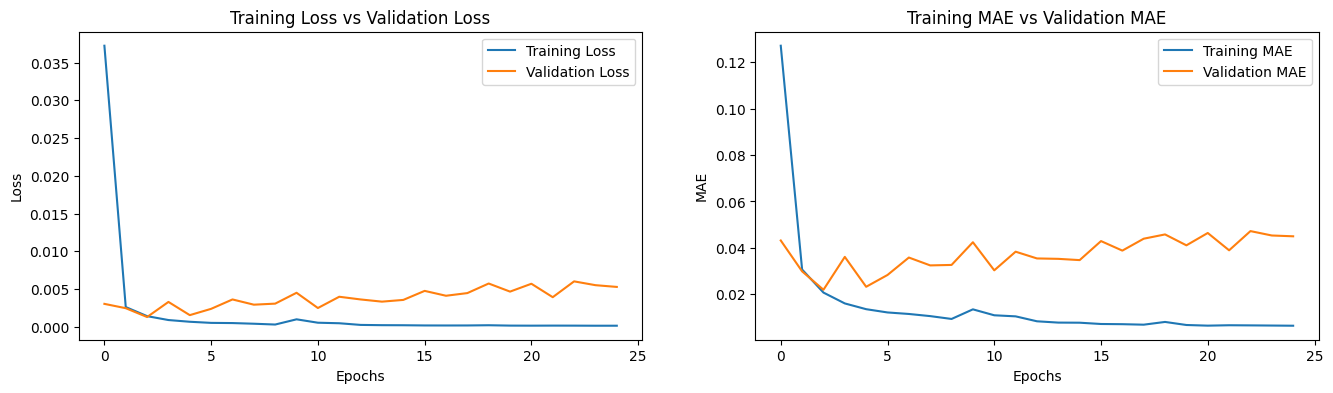

In [ ]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Student Model

### Hard Distillation

In [ ]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model
history_hard = student_model_hard.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the student model
val_loss_hard, val_mae_hard = student_model_hard.evaluate(X_test, Y_test)
print(f"Validation MAE (Hard Distillation): {val_mae_hard}")


Epoch 1/25
188/188 [==============================] - 2s 4ms/step - loss: 0.0841 - mae: 0.1941 - val_loss: 0.1071 - val_mae: 0.2923
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0448 - mae: 0.1510 - val_loss: 0.0690 - val_mae: 0.2433
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0296 - mae: 0.1190 - val_loss: 0.0201 - val_mae: 0.1278
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0135 - mae: 0.0788 - val_loss: 0.0052 - val_mae: 0.0501
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0070 - mae: 0.0546 - val_loss: 0.0027 - val_mae: 0.0347
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0052 - mae: 0.0458 - val_loss: 0.0011 - val_mae: 0.0239
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0045 - mae: 0.0410 - val_loss: 0.0051 - val_mae: 0.0475
Epoch 8/25
188/188 [==============================] - 1s 3ms/step - loss: 0.

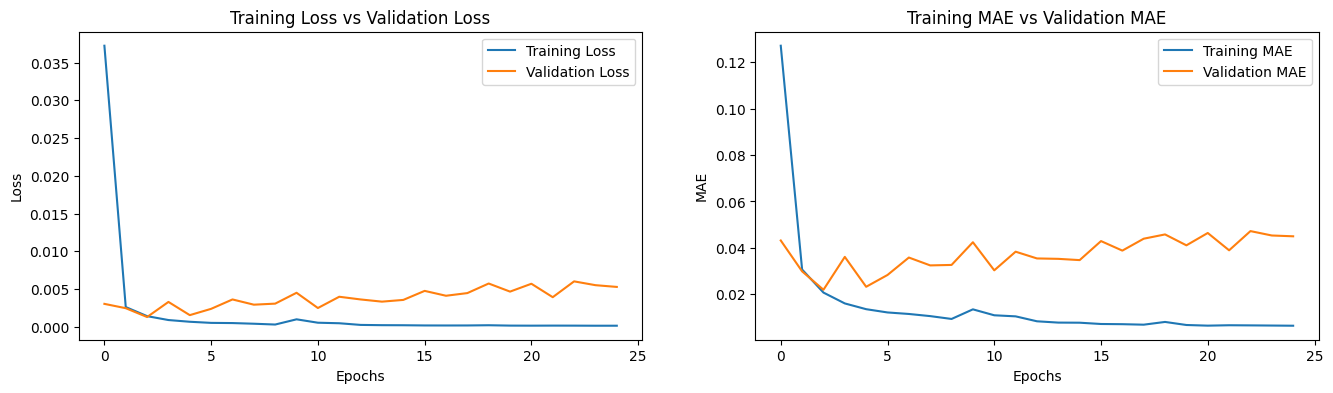

In [ ]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


### Soft Distilaltion

In [ ]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [ ]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 5ms/step - loss: 0.0714 - mae: 0.1974 - val_loss: 0.0266 - val_mae: 0.1450
Epoch 2/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0188 - mae: 0.1068 - val_loss: 0.0200 - val_mae: 0.1265
Epoch 3/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0133 - mae: 0.0876 - val_loss: 0.0123 - val_mae: 0.0987
Epoch 4/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0089 - mae: 0.0705 - val_loss: 0.0060 - val_mae: 0.0647
Epoch 5/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0062 - mae: 0.0581 - val_loss: 0.0036 - val_mae: 0.0451
Epoch 6/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0051 - mae: 0.0518 - val_loss: 0.0030 - val_mae: 0.0391
Epoch 7/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0042 - mae: 0.0467 - val_loss: 0.0031 - val_mae: 0.0390
Epoch 8/25
188/188 [=

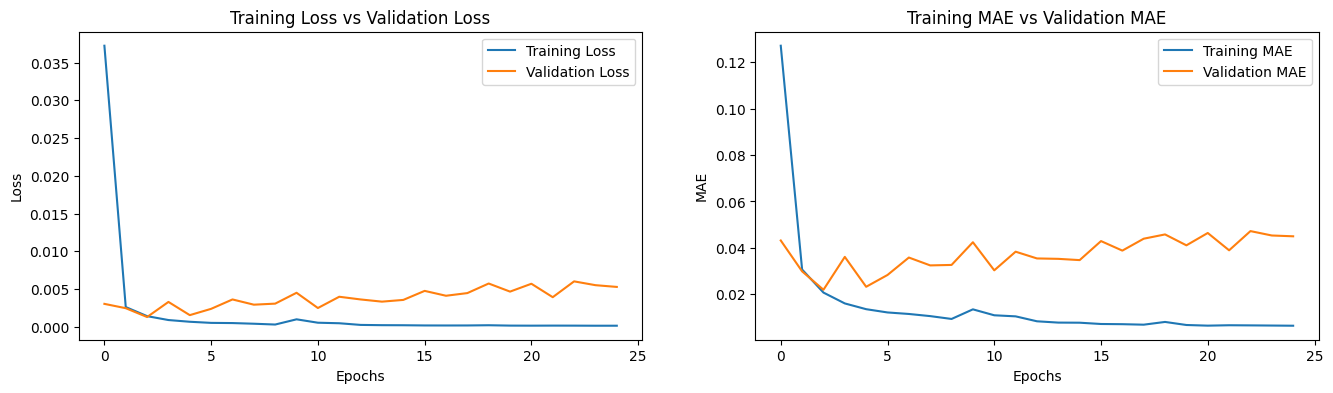

In [ ]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [ ]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 2s 3ms/step
Epoch 1/25
188/188 [==============================] - 2s 4ms/step - loss: 0.0695 - mae: 0.1955 - val_loss: 0.0229 - val_mae: 0.1359
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0178 - mae: 0.1030 - val_loss: 0.0160 - val_mae: 0.1119
Epoch 3/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0118 - mae: 0.0818 - val_loss: 0.0102 - val_mae: 0.0883
Epoch 4/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0084 - mae: 0.0685 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0062 - mae: 0.0592 - val_loss: 0.0040 - val_mae: 0.0463
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0046 - mae: 0.0508 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0021 - val_mae: 0.0324
Epoch 8/25
188/188 [=

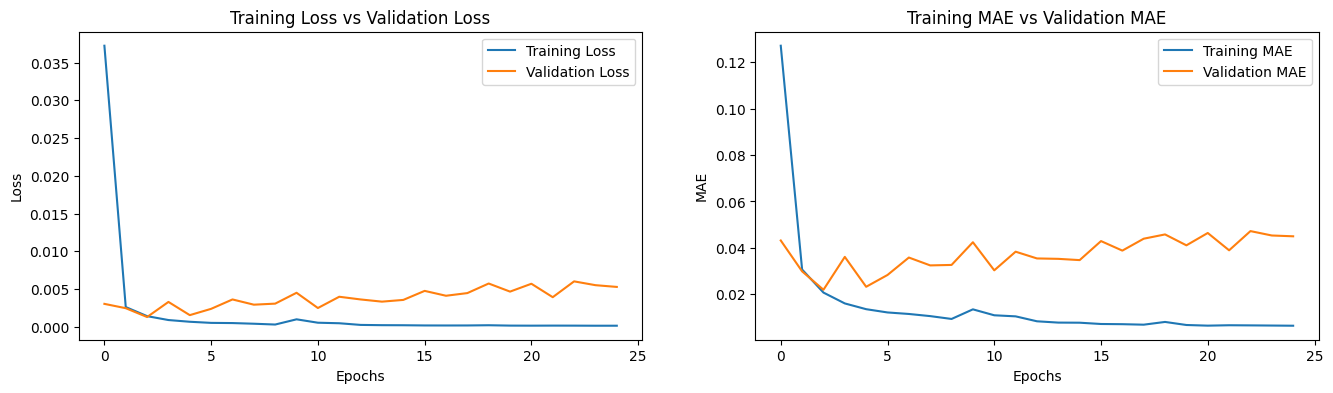

In [ ]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [ ]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 6ms/step - loss: 0.0825 - mae: 0.2091 - val_loss: 0.0238 - val_mae: 0.1404
Epoch 2/25
188/188 [==============================] - 1s 5ms/step - loss: 0.0155 - mae: 0.0948 - val_loss: 0.0181 - val_mae: 0.1205
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0117 - mae: 0.0814 - val_loss: 0.0122 - val_mae: 0.0937
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0085 - mae: 0.0698 - val_loss: 0.0069 - val_mae: 0.0651
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0064 - mae: 0.0617 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0556 - val_loss: 0.0036 - val_mae: 0.0449
Epoch 7/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0044 - mae: 0.0497 - val_loss: 0.0026 - val_mae: 0.0369
Epoch 8/25
188/188 [=

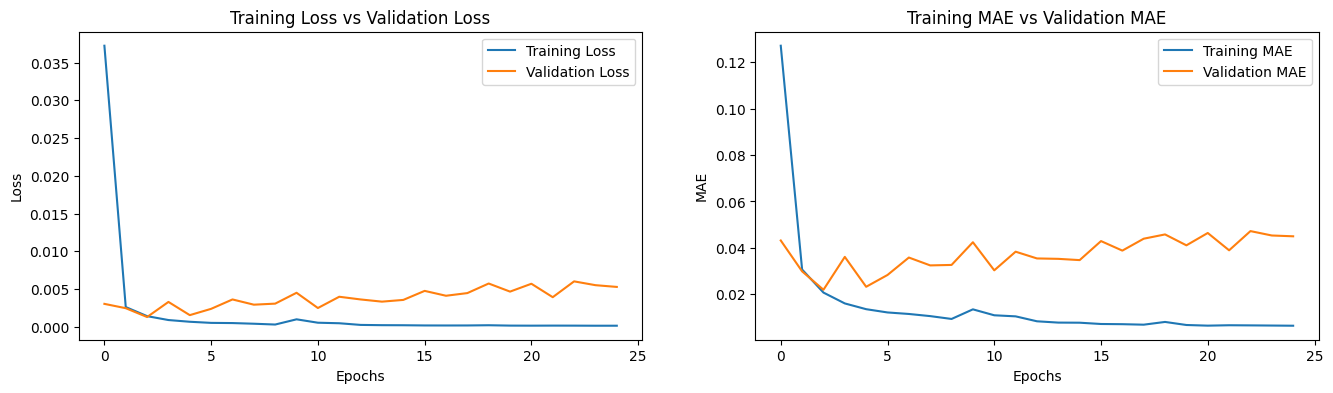

In [ ]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Time Comparison

In [ ]:
# Timing and memory usage measurement function
def measure_training_time_memory(model, x_train, y_train, epochs=50):
    start_time = time.time()
    mem_usage = memory_usage((model.fit, (x_train, y_train), {'epochs': epochs, 'batch_size': 32, 'validation_split': 0.2, 'callbacks': [tf.keras.callbacks.EarlyStopping(patience=5)]}), interval=0.1)
    end_time = time.time()
    training_time = end_time - start_time
    max_memory = max(mem_usage)
    return training_time, max_memory

In [ ]:
# Prepare soft targets for soft distillation
temperature = 3
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)
Y_train = Y_train.reshape(-1, 1)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, Y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)



469/469 [==============================] - 1s 2ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 2s 6ms/step - loss: 1.5821e-04 - mae: 0.0074 - val_loss: 0.0059 - val_mae: 0.0478
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 2.4417e-04 - mae: 0.0086 - val_loss: 0.0057 - val_mae: 0.0452
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0162 - val_loss: 0.0037 - val_mae: 0.0372
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 2.5751e-04 - mae: 0.0094 - val_loss: 0.0070 - val_mae: 0.0516
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 1.6910e-04 - mae: 0.0075 - val_loss: 0.0047 - val_mae: 0.0412
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 1.7657e-04 - mae: 0.0072 - val_loss: 0.0068 - val_mae: 0.0502
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 1.5503e-04 - mae: 0.0072 - val_loss: 0.0070 - val_mae: 0.0510
Epoch 8/50
375/375 [==============================] 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0310 - val_loss: 0.0022 - val_mae: 0.0299
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0027 - mae: 0.0309 - val_loss: 0.0024 - val_mae: 0.0324
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0026 - mae: 0.0303 - val_loss: 0.0011 - val_mae: 0.0225
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0017 - val_mae: 0.0258
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0025 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0265
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0027 - mae: 0.0305 - val_loss: 0.0035 - val_mae: 0.0399
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0022 - val_mae: 0.0307
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Soft Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 1s 3ms/step - loss: 9.9024e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mae: 0.0199
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 9.9229e-04 - mae: 0.0178 - val_loss: 9.1551e-04 - val_mae: 0.0177
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 8.2265e-04 - mae: 0.0162 - val_loss: 6.9927e-04 - val_mae: 0.0167
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 8.3324e-04 - mae: 0.0160 - val_loss: 5.2857e-04 - val_mae: 0.0145
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 8.6960e-04 - mae: 0.0162 - val_loss: 7.0211e-04 - val_mae: 0.0170
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 7.9237e-04 - mae: 0.0155 - val_loss: 6.1860e-04 - val_mae: 0.0163
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 7.7819e-04 - mae: 0.0153 - val_loss: 0.0029 - val_mae: 0.0311
Epoch 8/50
375/375 [========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
print(f"Teacher Model - Training Time: {teacher_time} seconds, Memory Usage: {teacher_memory} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time} seconds, Memory Usage: {student_hard_memory} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time} seconds, Memory Usage: {student_soft_memory} MiB")

Teacher Model - Training Time: 19.38635015487671 seconds, Memory Usage: 1255.94921875 MiB
Student Model (Hard Distillation) - Training Time: 12.756946802139282 seconds, Memory Usage: 1277.15234375 MiB
Student Model (Soft Distillation) - Training Time: 12.959763765335083 seconds, Memory Usage: 1298.30078125 MiB


# USA Data Import

In [81]:
# Define the file path for the Excel file stored in Google Drive
file_path = '/content/drive/MyDrive/DataSet_USA_3k_5k.xlsx'

# Use pandas to read the Excel file located at the specified file path
data = pd.read_excel(file_path)

In [82]:
# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,Source,Destination,No. Spans,Total Distance(m),Number of ON channels
0,0.000000,0.000000,0.000096,0.000096,0.000096,0.000000,0.000096,0.0,0.000096,0.0,...,0.000000,0.000000,26.391513,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
1,0.000000,0.000096,0.000000,0.000096,0.000000,0.000096,0.000000,0.0,0.000000,0.0,...,0.000000,25.764675,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
2,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.0,0.000096,0.0,...,0.000000,0.000000,0.000000,24.616361,24.297057,trxHouston0,trxJacksonville58,23,2050305.0,26
3,0.000096,0.000096,0.000095,0.000095,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,22.810189,0.000000,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
4,0.000000,0.000000,0.000096,0.000000,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,21.211149,21.131602,21.349516,22.572032,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26


### Normalization

In [83]:
# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.977579
4    0.000000
Name: Power_1, dtype: float64 0    1.000000
1    1.000000
2    1.000000
3    0.025744
4    1.000000
Name: ASE_1, dtype: float64 0    0.00000
1    0.00000
2    0.00000
3    0.37318
4    0.00000
Name: NLI_1, dtype: float64 0    0.392857
1    0.392857
2    0.392857
3    0.392857
4    0.392857
Name: No. Spans, dtype: float64 0    0.39403
1    0.39403
2    0.39403
3    0.39403
4    0.39403
Name: Total Distance(m), dtype: float64
     GSNR_1
0  0.000000
1  0.000000
2  0.000000
3  0.013061
4  0.000000


### Path Wise Split

In [84]:
# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns], y[target_column])

# Display shapes to verify the split
print("Normalized data with equal path distribution in train and test data :\n")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)

Normalized data with equal path distribution in train and test data :

Train data shape: (30000, 230)
Test data shape: (6000, 230)
Train labels shape: (30000,)
Test labels shape: (6000,)


# Teacher Model

In [85]:
# Define a large teacher model architecture
teacher_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the teacher model
history = teacher_model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the teacher model
val_loss, val_mae = teacher_model.evaluate(X_test, Y_test)
print(f"Validation MAE: {val_mae}")


Epoch 1/25
375/375 [==============================] - 4s 7ms/step - loss: 0.0246 - mae: 0.0604 - val_loss: 4.6484e-05 - val_mae: 0.0061
Epoch 2/25
375/375 [==============================] - 3s 7ms/step - loss: 0.0072 - mae: 0.0272 - val_loss: 5.3645e-05 - val_mae: 0.0069
Epoch 3/25
375/375 [==============================] - 4s 11ms/step - loss: 5.1045e-04 - mae: 0.0102 - val_loss: 2.9099e-05 - val_mae: 0.0049
Epoch 4/25
375/375 [==============================] - 3s 7ms/step - loss: 2.6254e-04 - mae: 0.0076 - val_loss: 2.2954e-05 - val_mae: 0.0041
Epoch 5/25
375/375 [==============================] - 3s 7ms/step - loss: 1.4353e-04 - mae: 0.0057 - val_loss: 2.0453e-05 - val_mae: 0.0041
Epoch 6/25
375/375 [==============================] - 3s 7ms/step - loss: 9.0888e-05 - mae: 0.0048 - val_loss: 1.6668e-05 - val_mae: 0.0037
Epoch 7/25
375/375 [==============================] - 3s 8ms/step - loss: 7.9755e-05 - mae: 0.0042 - val_loss: 1.2735e-05 - val_mae: 0.0031
Epoch 8/25
375/375 [=======

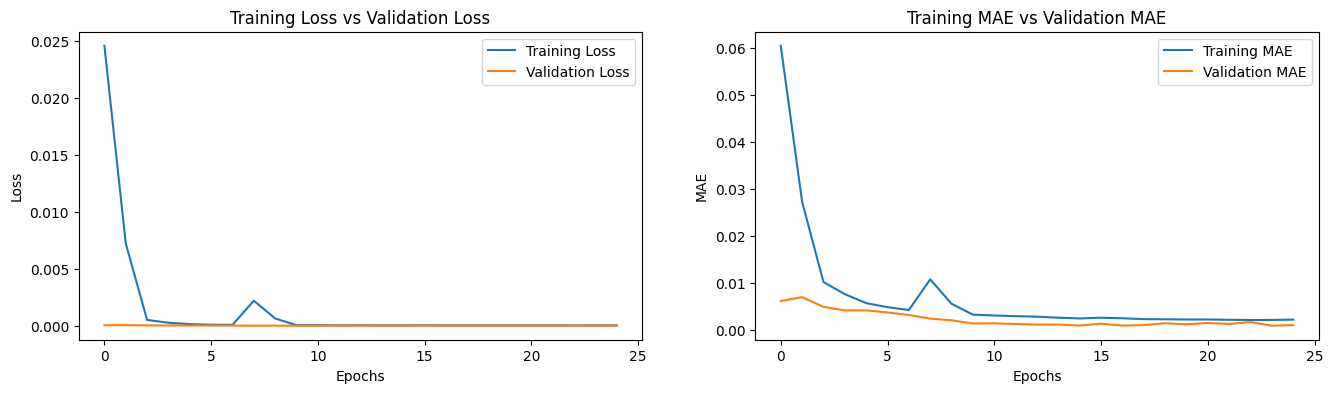

In [86]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Student Model

### Hard Distillation

In [87]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model
history_hard = student_model_hard.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the student model
val_loss_hard, val_mae_hard = student_model_hard.evaluate(X_test, Y_test)
print(f"Validation MAE (Hard Distillation): {val_mae_hard}")


Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0390 - mae: 0.0910 - val_loss: 2.6723e-04 - val_mae: 0.0142
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0252 - mae: 0.0658 - val_loss: 6.1967e-05 - val_mae: 0.0066
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0242 - mae: 0.0594 - val_loss: 4.4544e-05 - val_mae: 0.0055
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0240 - mae: 0.0577 - val_loss: 4.5482e-05 - val_mae: 0.0057
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0236 - mae: 0.0566 - val_loss: 3.6142e-05 - val_mae: 0.0050
Epoch 6/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0232 - mae: 0.0561 - val_loss: 4.0840e-05 - val_mae: 0.0056
Epoch 7/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0224 - mae: 0.0544 - val_loss: 2.0189e-05 - val_mae: 0.0036
Epoch 8/25
375/375 [============================

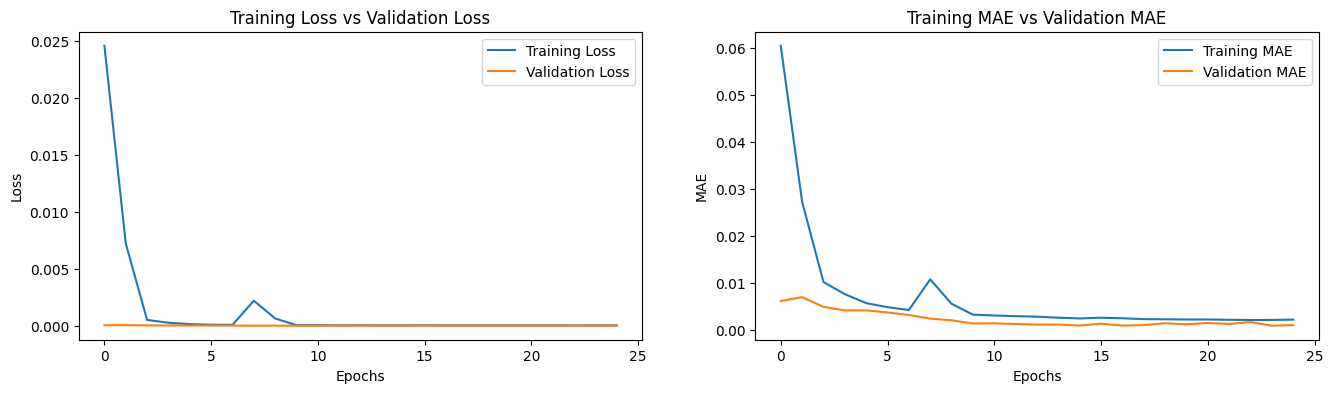

In [88]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


### Soft Distilaltion

In [89]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [93]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.values.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 3s 4ms/step
Epoch 1/25
375/375 [==============================] - 2s 3ms/step - loss: 0.0392 - mae: 0.1337 - val_loss: 0.0029 - val_mae: 0.0478
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0100 - mae: 0.0679 - val_loss: 1.8297e-04 - val_mae: 0.0103
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0076 - mae: 0.0526 - val_loss: 5.2697e-05 - val_mae: 0.0059
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0073 - mae: 0.0484 - val_loss: 4.4198e-05 - val_mae: 0.0052
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0068 - mae: 0.0443 - val_loss: 2.2926e-05 - val_mae: 0.0029
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0064 - mae: 0.0404 - val_loss: 1.5252e-05 - val_mae: 0.0028
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0062 - mae: 0.0371 - val_loss: 1.9662e-05 - val_mae: 0.00

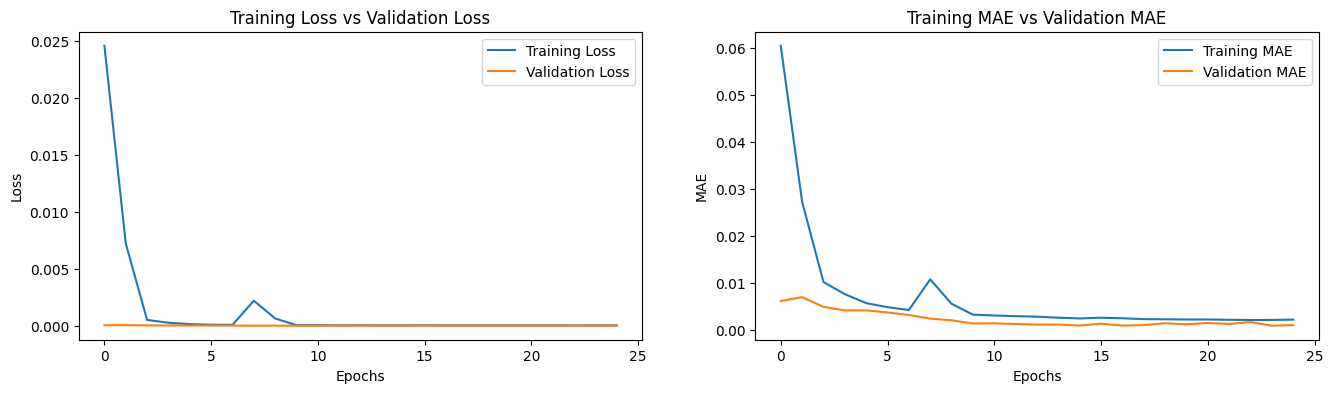

In [94]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [96]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 2s 2ms/step
Epoch 1/25
375/375 [==============================] - 3s 5ms/step - loss: 0.0275 - mae: 0.1123 - val_loss: 0.0020 - val_mae: 0.0405
Epoch 2/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0087 - mae: 0.0605 - val_loss: 4.0964e-04 - val_mae: 0.0183
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0075 - mae: 0.0507 - val_loss: 1.1482e-04 - val_mae: 0.0092
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0068 - mae: 0.0456 - val_loss: 9.0107e-05 - val_mae: 0.0087
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0065 - mae: 0.0412 - val_loss: 5.1661e-05 - val_mae: 0.0064
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0062 - mae: 0.0375 - val_loss: 2.2057e-05 - val_mae: 0.0038
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0060 - mae: 0.0345 - val_loss: 1.8363e-05 - val_mae: 0.00

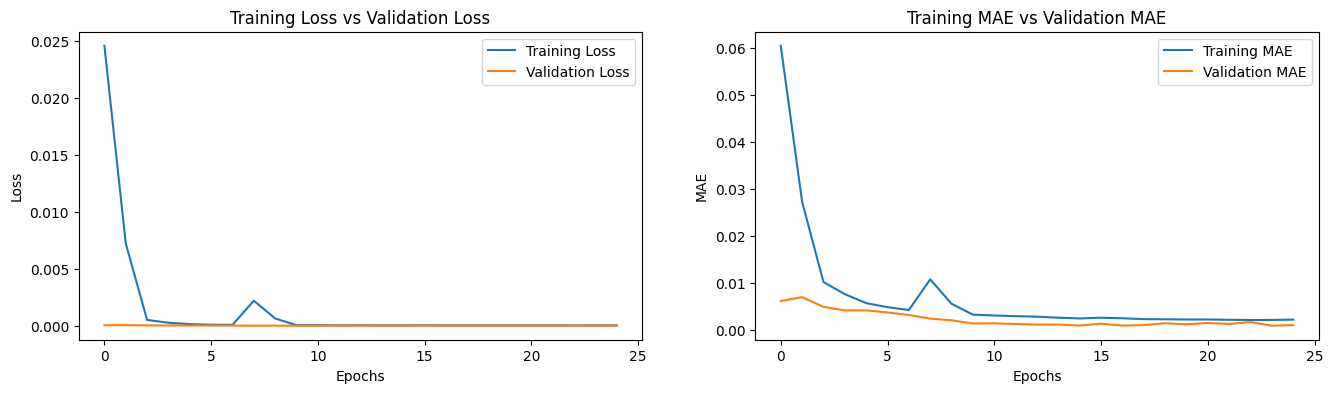

In [97]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [98]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 2s 2ms/step
Epoch 1/25
375/375 [==============================] - 3s 5ms/step - loss: 0.0522 - mae: 0.1537 - val_loss: 0.0018 - val_mae: 0.0358
Epoch 2/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0110 - mae: 0.0726 - val_loss: 1.6334e-04 - val_mae: 0.0090
Epoch 3/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0083 - mae: 0.0567 - val_loss: 3.7490e-05 - val_mae: 0.0042
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0074 - mae: 0.0503 - val_loss: 2.6568e-05 - val_mae: 0.0034
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0070 - mae: 0.0464 - val_loss: 4.5580e-05 - val_mae: 0.0057
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0068 - mae: 0.0427 - val_loss: 1.7838e-05 - val_mae: 0.0035
Epoch 7/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0064 - mae: 0.0386 - val_loss: 5.4098e-05 - val_mae: 0.00

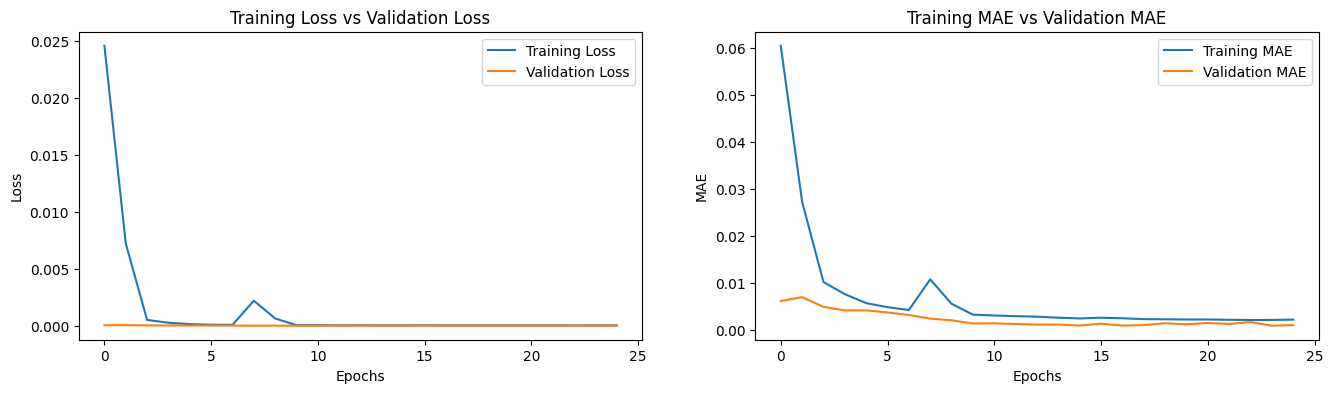

In [99]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Time Comparison

In [114]:
# Prepare soft targets for soft distillation
temperature = 3
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, Y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)



938/938 [==============================] - 5s 5ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 5s 6ms/step - loss: 2.9484e-04 - mae: 0.0033 - val_loss: 2.7710e-06 - val_mae: 0.0010
Epoch 2/50
750/750 [==============================] - 6s 7ms/step - loss: 1.5966e-04 - mae: 0.0029 - val_loss: 2.9237e-06 - val_mae: 9.7203e-04
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 3.5073e-04 - mae: 0.0035 - val_loss: 2.0927e-06 - val_mae: 7.5259e-04
Epoch 4/50
750/750 [==============================] - 4s 5ms/step - loss: 1.7157e-04 - mae: 0.0029 - val_loss: 1.5027e-06 - val_mae: 8.8610e-04
Epoch 5/50
750/750 [==============================] - 4s 5ms/step - loss: 1.2343e-04 - mae: 0.0030 - val_loss: 6.3235e-06 - val_mae: 0.0024
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 1.0257e-04 - mae: 0.0032 - val_loss: 3.3868e-06 - val_mae: 9.6955e-04
Epoch 7/50
750/750 [==============================] - 4s 6ms/step - loss: 2.6400e-04 - mae: 0.0034 - val_loss: 6.6993e-06 - val_mae: 0.0022
Epoc

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Hard Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0014 - mae: 0.0127 - val_loss: 3.7285e-05 - val_mae: 0.0060
Epoch 2/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0013 - mae: 0.0123 - val_loss: 2.9815e-05 - val_mae: 0.0053
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0013 - mae: 0.0123 - val_loss: 1.3056e-05 - val_mae: 0.0035
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0013 - mae: 0.0123 - val_loss: 6.0519e-05 - val_mae: 0.0075
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0012 - mae: 0.0121 - val_loss: 1.1585e-05 - val_mae: 0.0032
Epoch 6/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0013 - mae: 0.0123 - val_loss: 3.1485e-05 - val_mae: 0.0054
Epoch 7/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0013 - mae: 0.0122 - val_loss: 3.9656e-05 - val_mae: 0.0058
Epoch 8/50
750/750 [============================

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 4s 6ms/step - loss: 4.7251e-04 - mae: 0.0080 - val_loss: 1.3595e-05 - val_mae: 0.0032
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 4.7667e-04 - mae: 0.0081 - val_loss: 2.2965e-05 - val_mae: 0.0042
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 4.4718e-04 - mae: 0.0080 - val_loss: 2.5747e-05 - val_mae: 0.0046
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 4.6838e-04 - mae: 0.0080 - val_loss: 1.3280e-05 - val_mae: 0.0031
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 4.6378e-04 - mae: 0.0081 - val_loss: 1.2110e-05 - val_mae: 0.0027
Epoch 6/50
750/750 [==============================] - 3s 3ms/step - loss: 4.5855e-04 - mae: 0.0080 - val_loss: 1.1963e-05 - val_mae: 0.0028
Epoch 7/50
750/750 [==============================] - 4s 5ms/step - loss: 4.2510e-04 - mae: 0.0078 - val_loss: 1.2048e-05 - val_mae: 0.0029
Epoch 8/50
750/750 [

In [115]:
print(f"Teacher Model - Training Time: {teacher_time} seconds, Memory Usage: {teacher_memory} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time} seconds, Memory Usage: {student_hard_memory} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time} seconds, Memory Usage: {student_soft_memory} MiB")

Teacher Model - Training Time: 45.06104588508606 seconds, Memory Usage: 2189.8203125 MiB
Student Model (Hard Distillation) - Training Time: 27.034422397613525 seconds, Memory Usage: 2231.94921875 MiB
Student Model (Soft Distillation) - Training Time: 52.26564288139343 seconds, Memory Usage: 2274.05859375 MiB


# Conclusion

**Note :**

For fair comparison epochs are kept constant.

**Learnings :**

1) Teacher Model as in normal model takes longer to for inference. The larger the dataset or the model architecture the more evident is the time.

2) For student model Hard Distillation and Soft Distilaltion takes relatively similar times.

If we consider the time taken to calculate soft labels then the overall time for soft distillation is more as it requires an additional step.

3) In terms of accuracy the teacher model is most accurate as expected while the Hard Distillation as it utilizes the actual lables is second most accurate.

4) Soft Distillation is the least accurate.

5) The temperature values acts as the smoothing parameter for the output distribution.


*   
T=1 ; The soft lable calculation function becomes softmax function.
*   T>1 ; Smooths the actual label distribution while the accuracy decreases with higher values of T.

6) The hard distillation model training becomes same as the teacher model training if the model architectures are the same. The key difference is the utilization of the teacher model predictions in student model to gain insights.







